In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import ward, dendrogram

from gensim import corpora, models, similarities
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [3]:
df_train = pd.read_table('data/TrainingSet.txt', sep='\t')

In [4]:
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d.%m.%Y').dt.date
df_train['Event ID'] = df_train['Event ID'].fillna(0)

In [5]:
df_train.head()

,Date,Time,Trainig/Test,Event ID,Title,Link,Abstract
0,2019-02-05,18:45:44,Training,1.0,New dog food recall and latest warning on grai...,https://twitter.com/tweet/status/1092857075753...,New dog food recall and latest warning on grai...
1,2019-02-05,06:29:38,Training,1.0,New Dog Food Recall And The Latest Warning On ...,https://twitter.com/tweet/status/1092671572400...,New Dog Food Recall And The Latest Warning On ...
2,2019-02-05,18:40:20,Training,1.0,RT @BaybeeReade: Another dog food recall over ...,https://twitter.com/tweet/status/1092855599233...,RT @BaybeeReade: Another dog food recall over ...
3,2019-02-04,22:05:19,Training,1.0,Hill’s Pet Nutrition voluntary recall affects ...,https://twitter.com/tweet/status/1092544879400...,Hill’s Pet Nutrition voluntary recall affects ...
4,2019-02-05,08:53:45,Training,1.0,RT @mercnews: New dog food recall and the late...,https://twitter.com/tweet/status/1092707841809...,RT @mercnews: New dog food recall and the late...


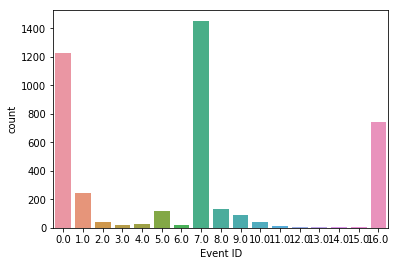

In [6]:
sns.countplot(x='Event ID', data=df_train)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

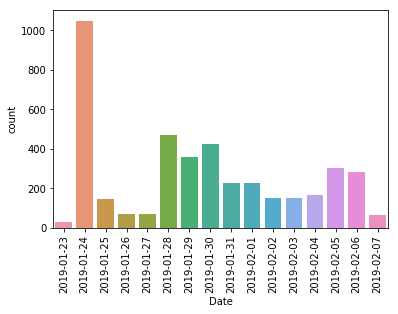

In [7]:
sns.countplot(x='Date', data=df_train, order = sorted(set(df_train['Date'])))
plt.xticks(rotation=90)

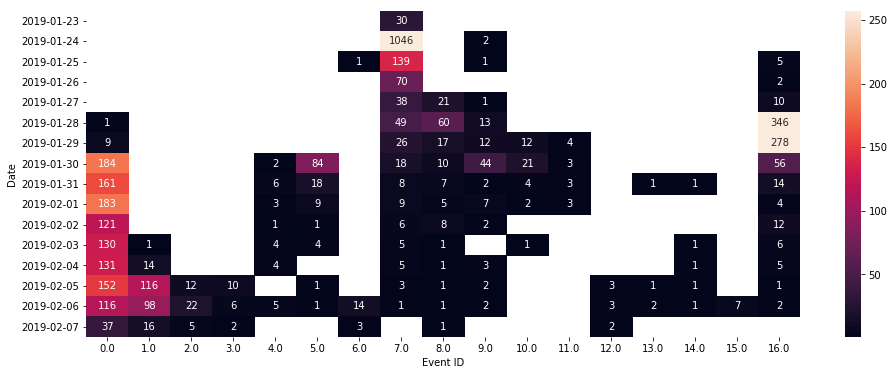

In [8]:
plt.figure(figsize=(16, 6))
pivot = df_train.groupby(['Date','Event ID'], as_index=False)['Link'].\
            agg({'count':len}).\
            pivot('Date','Event ID','count')
sns.heatmap(pivot, robust=True, annot=True, fmt='.4g')

# NLP

In [9]:
df_train['Abstract'].head()

0    New dog food recall and latest warning on grai...
1    New Dog Food Recall And The Latest Warning On ...
2    RT @BaybeeReade: Another dog food recall over ...
3    Hill’s Pet Nutrition voluntary recall affects ...
4    RT @mercnews: New dog food recall and the late...
Name: Abstract, dtype: object

In [10]:
stoplist = set(stopwords.words('english'))

### Tokenize and Remove Stopwords

In [11]:
def tokenize_and_filter_stopwords(raw_text):
    raw_text = str(raw_text)
    tokens = wordpunct_tokenize(raw_text)
    text = nltk.Text(tokens)
    words = [w.lower() for w in text if w.isalpha()]
    words = [word for word in words if word not in stoplist]

    return words

In [12]:
df_train['ab_clean'] = df_train['Abstract'].apply(tokenize_and_filter_stopwords)

In [13]:
df_train[['Abstract', 'ab_clean']].head()

,Abstract,ab_clean
0,New dog food recall and latest warning on grai...,"[new, dog, food, recall, latest, warning, grai..."
1,New Dog Food Recall And The Latest Warning On ...,"[new, dog, food, recall, latest, warning, grai..."
2,RT @BaybeeReade: Another dog food recall over ...,"[rt, baybeereade, another, dog, food, recall, ..."
3,Hill’s Pet Nutrition voluntary recall affects ...,"[hill, pet, nutrition, voluntary, recall, affe..."
4,RT @mercnews: New dog food recall and the late...,"[rt, mercnews, new, dog, food, recall, latest,..."


### Phrases Model

In [14]:
bigram_model = Phraser(Phrases(df_train['ab_clean']))
df_train['ab_clean_ph'] = df_train['ab_clean'].apply(lambda text: bigram_model[text])
df_train[['Abstract','ab_clean','ab_clean_ph']].head()

,Abstract,ab_clean,ab_clean_ph
0,New dog food recall and latest warning on grai...,"[new, dog, food, recall, latest, warning, grai...","[new, dog_food, recall, latest_warning, grain_..."
1,New Dog Food Recall And The Latest Warning On ...,"[new, dog, food, recall, latest, warning, grai...","[new, dog_food, recall, latest_warning, grain_..."
2,RT @BaybeeReade: Another dog food recall over ...,"[rt, baybeereade, another, dog, food, recall, ...","[rt, baybeereade, another_dog, food, recall, d..."
3,Hill’s Pet Nutrition voluntary recall affects ...,"[hill, pet, nutrition, voluntary, recall, affe...","[hill_pet, nutrition, voluntary, recall_affect..."
4,RT @mercnews: New dog food recall and the late...,"[rt, mercnews, new, dog, food, recall, latest,...","[rt, mercnews, new, dog_food, recall, latest_w..."


### Label Propagation

In [17]:
from sklearn.semi_supervised import LabelPropagation

In [34]:
label_prop_model = LabelPropagation()
label_prop_model.fit(X_train.toarray(), y_train)

LabelPropagation(alpha=None, gamma=20, kernel='rbf', max_iter=1000,
         n_jobs=None, n_neighbors=7, tol=0.001)

In [36]:
Y_pred = label_prop_model.predict(X_train.toarray())

In [38]:
from sklearn.metrics import accuracy_score,recall_score,f1_score

print("ACC",accuracy_score(y_train,Y_pred))
print("REC",recall_score(y_train,Y_pred,average="micro"))
print("F-score",f1_score(y_train,Y_pred,average="micro"))

ACC 0.9983265598852499
REC 0.9983265598852499
F-score 0.9983265598852499


## Baseline of supervised model

In [25]:
vectorizer = TfidfVectorizer(min_df=2, max_features=1000)
text_tfidf = vectorizer.fit_transform([' '.join(text) for text in df_train['ab_clean_ph']])
X_train = text_tfidf
y_train = df_train['Event ID']

In [16]:
param_test_lr =  {'C' :[10 ** x for x in list(range(-4,5,1))]}
gsearch_lr = GridSearchCV(estimator = LogisticRegression( 
        penalty='l1', 
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced'
    ),                   
    param_grid = param_test_lr, 
    cv = 5,
    n_jobs = 4)

gsearch_lr.fit(X_train,y_train)

/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
gsearch_lr.best_params_

{'C': 100}

In [20]:
gsearch_lr.best_score_

0.9765718383934975

## Load Test Data and Preprocess

In [21]:
df_test = pd.read_table('data/TestSet.txt', sep='\t')

In [22]:
df_test['Date'] = pd.to_datetime(df_train['Date'], format='%Y.%m.%d').dt.date
df_test['Event ID'] = df_train['Event ID'].fillna(0)

In [23]:
df_test.head()

,Date,Time,Training/Test,Title,Link,Abstract,Event ID
0,2019-02-05,23:59:31,Test,@pccs_heron Salmonella,https://twitter.com/tweet/status/1103807421800...,@pccs_heron Salmonella,1.0
1,2019-02-05,23:59:20,Test,@richardlanigan @trishgreenhalgh No. It's not ...,https://twitter.com/tweet/status/1103807373196...,@richardlanigan @trishgreenhalgh No. It's not ...,1.0
2,2019-02-05,23:59:02,Test,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,https://twitter.com/tweet/status/1103807299389...,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,1.0
3,2019-02-04,23:57:08,Test,20 percent of seafood is mislabeled! Global fo...,https://twitter.com/tweet/status/1103806821456...,20 percent of seafood is mislabeled! Global fo...,1.0
4,2019-02-05,23:56:52,Test,#EuropeanCourt decided that #foodsafety and #e...,https://twitter.com/tweet/status/1103806755656...,#EuropeanCourt decided that #foodsafety and #e...,1.0


In [24]:
df_test['ab_clean'] = df_test['Abstract'].apply(tokenize_and_filter_stopwords)

In [25]:
df_test[['Abstract', 'ab_clean']].head()

,Abstract,ab_clean
0,@pccs_heron Salmonella,[salmonella]
1,@richardlanigan @trishgreenhalgh No. It's not ...,"[richardlanigan, trishgreenhalgh, feaces, alon..."
2,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,"[patchouliw, beccicath, mavenofmayhem, swifton..."
3,20 percent of seafood is mislabeled! Global fo...,"[percent, seafood, mislabeled, global, food, s..."
4,#EuropeanCourt decided that #foodsafety and #e...,"[europeancourt, decided, foodsafety, environme..."


In [26]:
bigram_model_test = Phraser(Phrases(df_test['ab_clean']))
df_test['ab_clean_ph'] = df_test['ab_clean'].apply(lambda text: bigram_model_test[text])
df_test[['Abstract','ab_clean','ab_clean_ph']].head()

,Abstract,ab_clean,ab_clean_ph
0,@pccs_heron Salmonella,[salmonella],[salmonella]
1,@richardlanigan @trishgreenhalgh No. It's not ...,"[richardlanigan, trishgreenhalgh, feaces, alon...","[richardlanigan, trishgreenhalgh, feaces, alon..."
2,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOn...,"[patchouliw, beccicath, mavenofmayhem, swifton...","[patchouliw, beccicath, mavenofmayhem, swifton..."
3,20 percent of seafood is mislabeled! Global fo...,"[percent, seafood, mislabeled, global, food, s...","[percent, seafood, mislabeled, global, food_sa..."
4,#EuropeanCourt decided that #foodsafety and #e...,"[europeancourt, decided, foodsafety, environme...","[europeancourt, decided, foodsafety, environme..."


## LR_Model for Submission

In [27]:
vectorizer_test = TfidfVectorizer(min_df=2, max_features=1000)
text_tfidf_test = vectorizer_test.fit_transform([' '.join(text) for text in df_test['ab_clean_ph']])
X_test = text_tfidf_test

In [28]:
lr_model = LogisticRegression(
        penalty='l1',
        C=100,
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced').fit(X_train,y_train)

In [29]:
predictions = lr_model.predict(X_test)

In [30]:
score = lr_model.score(X_train, y_train)

In [31]:
print(score)

0.9971312455175712


In [32]:
df_results = pd.read_table('data/sample_results.txt', sep='\t')

In [33]:
df_results['Event ID'] = predictions

In [34]:
df_results.rename(columns={'Event ID':'Predicted Event ID'}, inplace=True)

In [35]:
df_results.to_csv('data/results.csv')